In [1]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

import date_transformer
import imputing_transformer
import column_extractor
import categorical_transformer
import cleanup_transformer
import ModelTransformer
import classification_model
import pandas_column_utilities

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

classification_model= reload(classification_model)


In [2]:
df = pd.read_csv("/Users/predev/Documents/Learn/MachineLearning/Galvanize/Case_Study_21-2/Data/churn_train.csv")

In [3]:
df = pd.read_csv("/Users/predev/Documents/Learn/MachineLearning/Galvanize/Case_Study_21-2/Data/churn_train.csv")
pandas_column_utilities.info(df)

,Count,,Type,Possible Values,Few Values
Column,,,,,
avg_dist,40000,non-null,float64,,"[6.94, 8.06, 21.5, 9.46, 13.77, 14.51, 4.87, 1..."
avg_rating_by_driver,39838,non-null,float64,,"[5.0, 4.0, 4.7, 4.8, 4.3, 4.6, 4.9, 4.4, 3.0, ..."
avg_rating_of_driver,33472,non-null,float64,,"[5.0, nan, 4.0, 4.7, 3.0, 3.7, 4.5, 3.3, 3.6, ..."
avg_surge,40000,non-null,float64,,"[1.0, 2.75, 2.0, 1.15, 1.02, 1.11, 1.2, 1.03, ..."
city,40000,non-null,object,,"[Astapor, Winterfell, King's Landing]"
last_trip_date,40000,non-null,object,{DATE},"[2014-05-03, 2014-01-26, 2014-05-21, 2014-01-1..."
phone,39681,non-null,object,,"[Android, iPhone, nan]"
signup_date,40000,non-null,object,{DATE},"[2014-01-12, 2014-01-25, 2014-01-02, 2014-01-0..."
surge_pct,40000,non-null,float64,,"[0.0, 100.0, 20.0, 9.1, 2.6, 14.3, 28.6, 11.1,..."


None


In [4]:
ordinal = {'luxury_car_user':{False:0,True:1}}
categorical = ['city','phone']
date_manip = ['signup_date']
cont = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']

#last_trip_date = leakage?
#active imbalanced class? No
#outliers miles
#rating categories
#user - signed up on weekday/weekend
date_la = datetime.strptime('2014-07-01','%Y-%m-%d')
df['active'] = df['last_trip_date'].apply(lambda x: 1 if date_la - datetime.strptime(x, '%Y-%m-%d') <= timedelta(days = 30) else 0)

In [5]:
date_la = datetime.strptime('2014-07-01','%Y-%m-%d')
df['active'] = df['last_trip_date'].apply(lambda x: 1 if date_la - datetime.strptime(x, '%Y-%m-%d') <= timedelta(days = 30) else 0)
df['active']

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       1
13       0
14       1
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       1
26       0
27       0
28       0
29       0
        ..
39970    1
39971    0
39972    0
39973    1
39974    1
39975    0
39976    1
39977    1
39978    0
39979    0
39980    0
39981    0
39982    0
39983    0
39984    0
39985    0
39986    1
39987    0
39988    0
39989    0
39990    0
39991    1
39992    0
39993    0
39994    1
39995    0
39996    0
39997    1
39998    0
39999    1
Name: active, dtype: int64

In [23]:
# Scatterplot Matrix
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix



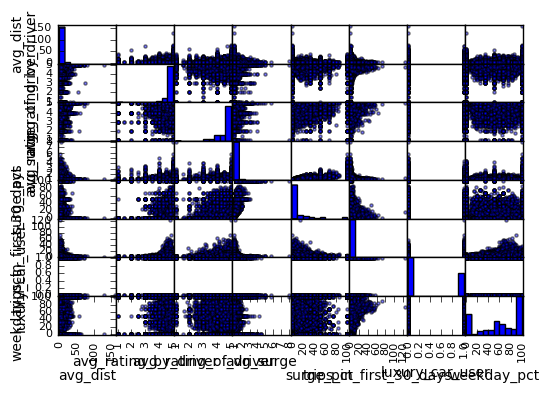

In [57]:
# fig = plt.figure(figsize=(400,40))
# scatter_matrix(df)
# plt.show()

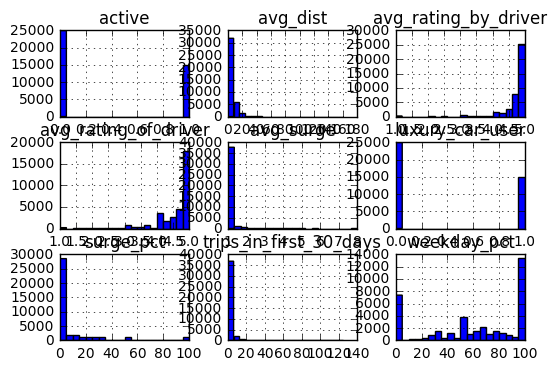

In [39]:
df.hist(bins = 20)
plt.show()

In [6]:
date_pip = Pipeline([('extract',column_extractor.column_extractor(date_manip)),
                ('date_manip', date_transformer.date_transformer('%Y-%m-%d')),
                ('d-m-y-q-dow', FeatureUnion([('day',date_transformer.day_of_month_transformer()),
                                            ('month',date_transformer.month_transformer()),
                                            ('dow',date_transformer.day_of_week_transformer()),
                                            ('quarter',date_transformer.month_quarter_transformer()),
                                            ('year',date_transformer.year_transformer())])),
                ('impute',imputing_transformer.imputing_transformer(Imputer(strategy='most_frequent')))])

continuous = Pipeline([
            ('extract', column_extractor.column_extractor(cont)),
            ('impute',imputing_transformer.imputing_transformer(Imputer(strategy='most_frequent'))),
            ('scale', Normalizer())])

ordinal_pip = Pipeline([('extract', column_extractor.column_extractor(ordinal)),
                        ('ord', categorical_transformer.ordinal_transformer(ordinal)),
                       ('impute',imputing_transformer.imputing_transformer(Imputer(strategy='most_frequent')))])

one_hot = Pipeline([('extract', column_extractor.column_extractor(categorical)),
                    ('lab_enc', categorical_transformer.label_transformer()),
                    ('one_hot', ModelTransformer.ModelTransformer(OneHotEncoder(sparse=False)))])


features = Pipeline([('parallel', FeatureUnion([('date',date_pip),
                                                ('continuous',continuous),
                                                ('ordinal_pip',ordinal_pip),
                                                ('one_hot',one_hot)])),
                    ('cleanup',cleanup_transformer.cleanup_transformer())])

In [29]:
select_features = Pipeline([('feat_imp',FeatureUnion([#('xtra_tree', SelectFromModel(ExtraTreesClassifier())),
                                                      ('lin',SelectFromModel(LinearSVC(penalty="l1", dual=False)))]))])

transform features
mp {False: 0, True: 1}
select features
model

Confusion matrix 
[[7748  523]
 [3562 1367]]
Accuracy  0.69053030303
precision  0.72328042328
recall  0.277338202475


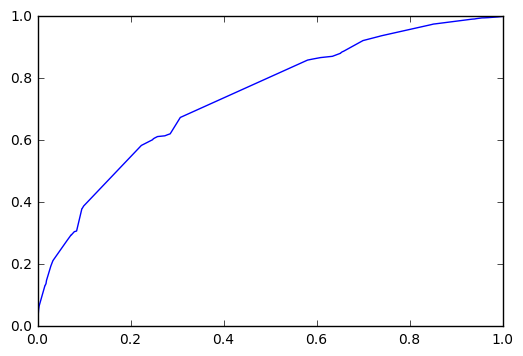

0.69053030303030305

In [30]:
#features 
print("transform features")
X_transform =  features.transform(df)

#select features - feature imp
print("select features")
y = df['active'].values
select_features.fit(X_transform, y)
X_feat = select_features.transform(X_transform) 

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.33, random_state=42)

print("model")
mod = classification_model.kfold_classification_model(ExtraTreesClassifier(max_depth=2))
mod.fit(X_train, y_train)
mod.score(X_test, y_test)


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighborsKNeighborsClassifier


Confusion matrix 
[[6895 1376]
 [2232 2697]]
Accuracy  0.726666666667
precision  0.66216547999
recall  0.547169811321


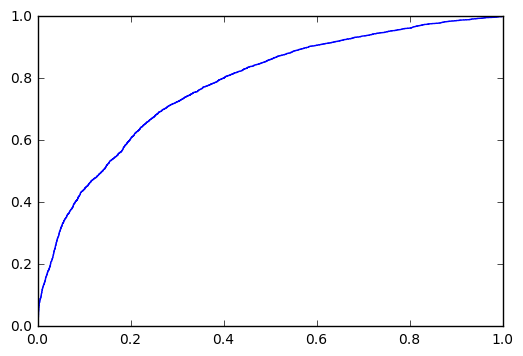

0.72666666666666668

In [33]:
param_grid = [
  {'C':[0.001, 0.01,0.1,1],'penalty':['l1','l2']}]
clf = GridSearchCV(LogisticRegression(), param_grid)
clf.fit(X_train, y_train)

mod1 = kfold_classification_model(clf)
mod1.score(X_test, y_test)


Confusion matrix 
[[6901 1370]
 [2114 2815]]
Accuracy  0.736060606061
precision  0.672640382318
recall  0.571109758572


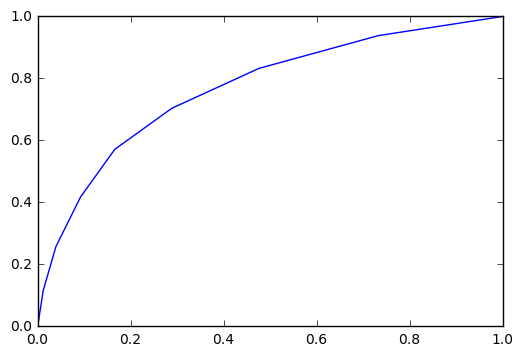

0.73606060606060608

In [36]:
#knn
param_grid = [
  {'n_neighbors':[3,5,7],'leaf_size':[5, 10,30,50,100]}]
clf = GridSearchCV(KNeighborsClassifier(), param_grid)
clf.fit(X_train, y_train)

mod2 = kfold_classification_model(clf)
mod2.score(X_test, y_test)

In [75]:
import models
import features

models = reload(models)
features = reload(features)

mp {False: 0, True: 1}
logit
{'penalty': 'l1', 'C': 1}

Confusion matrix 
[[6847 1424]
 [2318 2611]]
Accuracy  0.716515151515
precision  0.647087980173
recall  0.529722053155


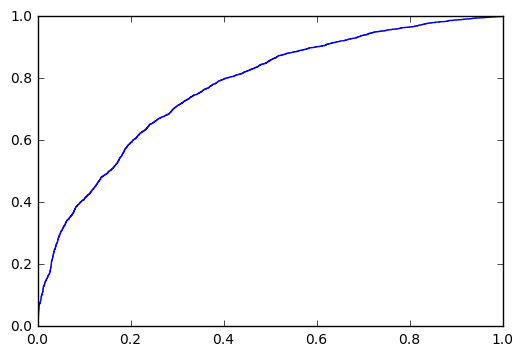

knn


KeyboardInterrupt: 

In [92]:
import models
import features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

models = reload(models)
features = reload(features)
feat, X = features.get_basic_features(df, ordinal, categorical,date_manip ,cont)
X_po = SelectKBest(chi2, k=10).fit_transform(X, y)
# X_po = select_features.transform(X)
y = df['active'].values
X_train, X_test, y_train, y_test = train_test_split(X_po, y, test_size=0.33, random_state=42)

print "logit"
models.run_logit(X_train, X_test, y_train, y_test)
print "knn"
models.run_knn(X_train, X_test, y_train, y_test)
print "random forest"
models.run_randomforestclassifier(X_train, X_test, y_train, y_test)
print "adaboost"
models.run_adaboost(X_train, X_test, y_train, y_test)


In [111]:
from sklearn.ensemble import RandomForestClassifier
feat, X = features.get_poly_features(df, ordinal, categorical,date_manip ,cont)
select_features = Pipeline([('xtra_tree', SelectFromModel(RandomForestClassifier(),threshold='median')),
                      ('lin',SelectFromModel(LinearSVC(penalty="l1", dual=False),threshold='median'))])
select_features.fit(X, y)
X_po = select_features.transform(X)
y = df['active'].values
X_train, X_test, y_train, y_test = train_test_split(X_po, y, test_size=0.33, random_state=42)

# print "logit"
# # models.run_logit(X_train, X_test, y_train, y_test)
# print "knn"
# # models.run_knn(X_train, X_test, y_train, y_test)
# print "random forest"
# models.run_randomforestclassifier(X_train, X_test, y_train, y_test)
# print "adaboost"
# models.run_adaboost(X_train, X_test, y_train, y_test)

mp {False: 0, True: 1}


logit
{'penalty': 'l1', 'C': 1}

Confusion matrix 
[[7133 1138]
 [2143 2786]]
Accuracy  0.751439393939
precision  0.70998980632
recall  0.565226212213


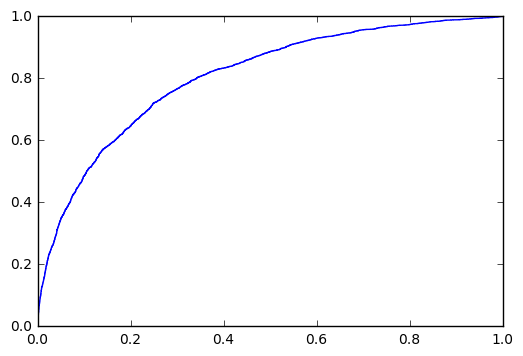

knn
{'n_neighbors': 7, 'leaf_size': 5}

Confusion matrix 
[[6920 1351]
 [1928 3001]]
Accuracy  0.751590909091
precision  0.689568014706
recall  0.608845607628


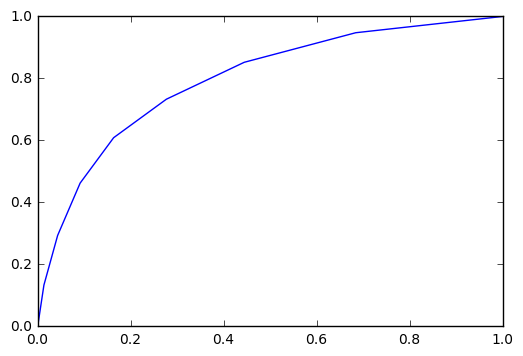

random forest
{'min_samples_split': 7, 'n_estimators': 50, 'oob_score': True, 'criterion': 'gini', 'max_depth': 10}

Confusion matrix 
[[7137 1134]
 [1755 3174]]
Accuracy  0.781136363636
precision  0.736768802228
recall  0.643944004869


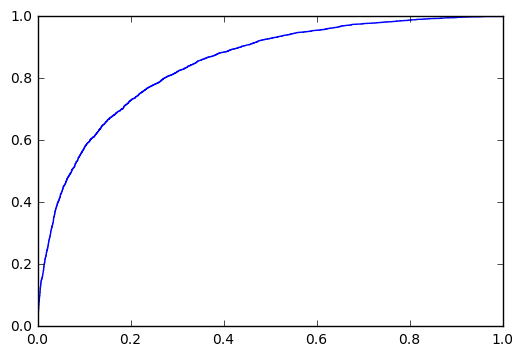

adaboost


KeyboardInterrupt: 

In [87]:
print "logit"
models.run_logit(X_train, X_test, y_train, y_test)
print "knn"
models.run_knn(X_train, X_test, y_train, y_test)
print "random forest"
models.run_randomforestclassifier(X_train, X_test, y_train, y_test)
print "adaboost"
models.run_adaboost(X_train, X_test, y_train, y_test)

In [ ]:
mod = RandomForestClassifier(min_samples_split= 7, 
                             n_estimators= 50, 
                             oob_score= True, criterion= 'gini', 
                             max_depth= 10)
mod2 = kfold_classification_model(mod)
mod2.fit(X_po, y)

In [99]:
df1 = pd.read_csv("/Users/predev/Documents/Learn/MachineLearning/Galvanize/Case_Study_21-2/Data/churn_test.csv")
pandas_column_utilities.info(df1)

,Count,,Type,Possible Values,Few Values
Column,,,,,
avg_dist,10000,non-null,float64,,"[2.48, 10.81, 12.95, 3.92, 1.46, 10.69, 3.0, 2..."
avg_rating_by_driver,9961,non-null,float64,,"[5.0, 4.3, 4.9, 1.0, 4.5, 4.8, 4.6, 4.7, 3.0, ..."
avg_rating_of_driver,8406,non-null,float64,,"[5.0, nan, 4.5, 3.3, 4.7, 4.8, 4.9, 4.6, 3.9, ..."
avg_surge,10000,non-null,float64,,"[1.0, 1.13, 1.14, 1.83, 1.04, 1.16, 1.11, 1.25..."
city,10000,non-null,object,,"[Winterfell, Astapor, King's Landing]"
last_trip_date,10000,non-null,object,{DATE},"[2014-01-07, 2014-04-29, 2014-01-29, 2014-02-1..."
phone,9923,non-null,object,,"[Android, iPhone, nan]"
signup_date,10000,non-null,object,{DATE},"[2014-01-06, 2014-01-19, 2014-01-09, 2014-01-0..."
surge_pct,10000,non-null,float64,,"[0.0, 16.7, 14.3, 66.7, 8.2, 10.9, 10.4, 28.6,..."


None


In [100]:
f, xt = features.get_poly_features(df1, ordinal, categorical,date_manip ,cont)

mp {False: 0, True: 1}


In [103]:
date_la = datetime.strptime('2014-07-01','%Y-%m-%d')
df1['active'] = df1['last_trip_date'].apply(lambda x: 1 if date_la - datetime.strptime(x, '%Y-%m-%d') <= timedelta(days = 30) else 0)
yt = df1['active']


In [104]:
X_test_tra = select_features.transform(xt)


Confusion matrix 
[[5296  932]
 [1384 2388]]
Accuracy  0.7684
precision  0.719277108434
recall  0.633085896076


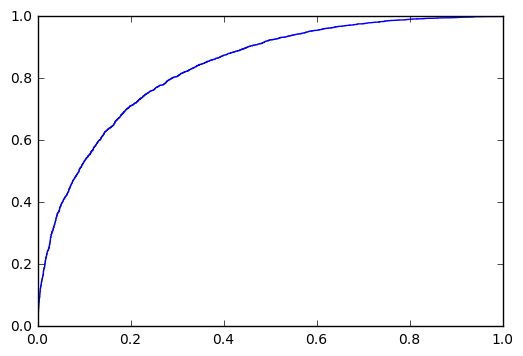

0.76839999999999997

In [110]:
mod2.score(X_test_tra, yt)

10000